# Comparaison CUST/Navigocorpus
Objectif: quantifier et localiser le différentiel entres navires envoyés en Angleterre depuis Navigo et l'équivalent en arrivée côté CUST.

*N.B.: la catégorie french_others ne fonctionne pas pour le moment car Navigo n'a pas les données adéquates pour 1789*

In [173]:
import csv
import pandas as pd
import seaborn as sns
from ebbe import grouped
from collections import Counter
from dunkerquesprint import get_online_csv
import pylab
import matplotlib.pyplot as plt

In [174]:
DUNKERQUE_UHGS_ID = 'A0204180'
GRAVELINES_UHGS_ID = 'A0189462'
FAKE_LISBONNE_UGHS_ID = 'A0394917'

## Agrégation CUST

In [175]:
CUST = get_online_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8LwvvPQUi0-srwNYbvTi1JC2eoTl_97usPeSChfsXStCMYi8SIh7onIHo1_z2mg/pub?output=csv')

Exclure ou conserver seulement les ports anglais codés dans navigo (avec un uhgs_id)

In [176]:
CUST = [r for r in CUST if r['uhgs_id'] != '#N/A']

In [177]:
len(CUST)

45

In [178]:
UHGS_ID_TO_PORT_NAME = {row['uhgs_id']: row['Names of the ports'] for row in CUST}

In [179]:
CUST_AGGREGATED_FLOWS = {
    ('british', 'french_flanders'): sum(int(row['from French Flanders_British vessels_Nb'] or '0') for row in CUST),
    ('british', 'french_others'): sum(int(row['From France_British vessels_Nb'] or '0') for row in CUST),
    ('foreign', 'french_flanders'): sum(int(row['from French Flanders__foreign_vessels_Nb'] or '0') for row in CUST),
    ('foreign', 'french_others'): sum(int(row['From France_foreign vessels_Nb'] or '0') for row in CUST)
}
CUST_AGGREGATED_FLOWS

{('british', 'french_flanders'): 169,
 ('british', 'french_others'): 1333,
 ('foreign', 'french_flanders'): 3,
 ('foreign', 'french_others'): 270}

In [180]:
# Ces données agrégées sont  saisies à la main le matin depuis infos de Silvia
# Fichier PDF source https://drive.google.com/file/d/17EvgPNYG4xbrcVe8Uad54-q1EP8-w1RS/view?usp=sharing
CUST_AGGREGATED_FLOWS_1787 = {
    ('british', 'french_flanders'): 381,
    ('british', 'french_others'): 1066,
    ('foreign', 'french_flanders'): 34,
    ('foreign', 'french_others'): 307
}

In [181]:
CUST_AGGREGATED_TONS = {
    ('british', 'french_flanders'): sum(int(row['from French Flanders__British vessels_tons'] or '0') for row in CUST),
    ('british', 'french_others'): sum(int(row['From France_British vessels_tons'] or '0') for row in CUST),
    ('foreign', 'french_flanders'): sum(int(row['from French Flanders__foreign_vessels_tons'] or '0') for row in CUST),
    ('foreign', 'french_others'): sum(int(row['From France_foreign vessels_tons'] or '0') for row in CUST)
}
CUST_AGGREGATED_TONS

{('british', 'french_flanders'): 18615,
 ('british', 'french_others'): 3550248,
 ('foreign', 'french_flanders'): 450,
 ('foreign', 'french_others'): 9548}

In [182]:
# Ces données sont agrégées et extrapolées à la main
CUST_AGGREGATED_TONS_1787 = {
    ('british', 'french_flanders'): 36_895,
    ('british', 'french_others'): 74_373,
    ('foreign', 'french_flanders'): 3005,
    ('foreign', 'french_others'): 12_548
}

In [183]:
CUST_UHGS_IDS = set(row['uhgs_id'] for row in CUST)
len(CUST_UHGS_IDS)

45

In [184]:
# Ajustement des données 1787 CUST au doigt mouillé en enlevant une portion correspondant aux Flandres autrichiennes
PART_FRENCH_FLANDERS_CUST_FLOWS_1789 = 169 / (169 + 295)
print(PART_FRENCH_FLANDERS_CUST_FLOWS_1789)

PART_FRENCH_FLANDERS_CUST_TONS_1789 = 18_615 / (18_615 + 28_814)
print(PART_FRENCH_FLANDERS_CUST_TONS_1789)

for k in CUST_AGGREGATED_FLOWS_1787:
    if 'french_others' in k:
        continue
    CUST_AGGREGATED_FLOWS_1787[k] *= PART_FRENCH_FLANDERS_CUST_FLOWS_1789
    
for k in CUST_AGGREGATED_TONS_1787:
    if 'french_others' in k:
        continue
    CUST_AGGREGATED_TONS_1787[k] *= PART_FRENCH_FLANDERS_CUST_TONS_1789

0.3642241379310345
0.3924813932404225


In [185]:
CUST_AGGREGATED_FLOWS_1787, CUST_AGGREGATED_TONS_1787

({('british', 'french_flanders'): 138.76939655172413,
  ('british', 'french_others'): 1066,
  ('foreign', 'french_flanders'): 12.383620689655173,
  ('foreign', 'french_others'): 307},
 {('british', 'french_flanders'): 14480.601003605389,
  ('british', 'french_others'): 74373,
  ('foreign', 'french_flanders'): 1179.4065866874696,
  ('foreign', 'french_others'): 12548})

## Agrégation Navigocorpus

In [186]:
with open('../../data/navigo_all_flows_1789.csv', encoding='UTF8') as f:
    NAVIGO = list(csv.DictReader(f))

In [187]:
with open('../../data/navigo_all_flows_1787.csv', encoding='UTF8') as f:
    NAVIGO_1787 = list(csv.DictReader(f))

Variables intéressantes: `departure_*`, `flag`, `homeport_uhgs_id`, `destination_state_1789_fr`

In [188]:
# On ne garde que les flux qui partent pour la grande bretagne
# NAVIGO = [r for r in NAVIGO if r['destination_state_1789_fr'] == 'Grande-Bretagne']
# NAVIGO = [r for r in NAVIGO if r['destination_substate_1789_fr'] == 'Angleterre']
filter_uhgs = CUST_UHGS_IDS | {FAKE_LISBONNE_UGHS_ID}
NAVIGO = [r for r in NAVIGO if r['destination_uhgs_id'] in filter_uhgs]
NAVIGO_1787 = [r for r in NAVIGO_1787 if r['destination_uhgs_id'] in filter_uhgs]

In [189]:
len(NAVIGO), len(NAVIGO_1787)

(1460, 2772)

In [190]:
def navigo_group(row):
    return (
        'british' if row['ship_flag_standardized_fr'] == 'britannique' else 'foreign',
        'french_flanders' if row['departure_uhgs_id'] in [DUNKERQUE_UHGS_ID, GRAVELINES_UHGS_ID] else 'french_other'
    )

NAVIGO_GROUPED = grouped(NAVIGO, key=navigo_group)
NAVIGO_GROUPED_1787 = grouped(NAVIGO_1787, key=navigo_group)

In [191]:
NAVIGO_AGGREGATED_FLOWS = {k: len(v) for k, v in NAVIGO_GROUPED.items()}
NAVIGO_AGGREGATED_FLOWS

{('british', 'french_flanders'): 1361,
 ('british', 'french_other'): 84,
 ('foreign', 'french_flanders'): 11,
 ('foreign', 'french_other'): 4}

In [192]:
NAVIGO_AGGREGATED_FLOWS_1787 = {k: len(v) for k, v in NAVIGO_GROUPED_1787.items()}
NAVIGO_AGGREGATED_FLOWS_1787

{('british', 'french_other'): 1268,
 ('foreign', 'french_flanders'): 19,
 ('foreign', 'french_other'): 260,
 ('british', 'french_flanders'): 1225}

In [193]:
NAVIGO_AGGREGATED_TONS = {k: sum(int(row['tonnage']) for row in v if row['tonnage']) for k, v in NAVIGO_GROUPED.items()}
NAVIGO_AGGREGATED_TONS

{('british', 'french_flanders'): 37842,
 ('british', 'french_other'): 10152,
 ('foreign', 'french_flanders'): 499,
 ('foreign', 'french_other'): 311}

In [194]:
NAVIGO_AGGREGATED_TONS_1787 = {k: sum(float(row['tonnage']) for row in v if row['tonnage']) for k, v in NAVIGO_GROUPED_1787.items()}
NAVIGO_AGGREGATED_TONS_1787

{('british', 'french_other'): 70771.5,
 ('foreign', 'french_flanders'): 1055.0,
 ('foreign', 'french_other'): 5826.0,
 ('british', 'french_flanders'): 31245.0}

## Comparaison

In [195]:
print('Flows')
for cust, navigo in zip(sorted(CUST_AGGREGATED_FLOWS.items()), sorted(NAVIGO_AGGREGATED_FLOWS.items())):
    if cust[0][1] == 'french_others':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Flows
For ('british', 'french_flanders') CUST: 169 NAVIGO: 1361 8.053254
For ('foreign', 'french_flanders') CUST: 3 NAVIGO: 11 3.666667


In [196]:
print('Tons')
for cust, navigo in zip(sorted(CUST_AGGREGATED_TONS.items()), sorted(NAVIGO_AGGREGATED_TONS.items())):
    if cust[0][1] == 'french_others':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Tons
For ('british', 'french_flanders') CUST: 18615 NAVIGO: 37842 2.032877
For ('foreign', 'french_flanders') CUST: 450 NAVIGO: 499 1.108889


In [197]:
print('Flows 1787')
for cust, navigo in zip(sorted(CUST_AGGREGATED_FLOWS_1787.items()), sorted(NAVIGO_AGGREGATED_FLOWS_1787.items())):
    if cust[0][1] == 'french_flanders':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Flows 1787
For ('british', 'french_others') CUST: 1066 NAVIGO: 1268 1.189493
For ('foreign', 'french_others') CUST: 307 NAVIGO: 260 0.846906


In [198]:
print('Tons 1787')
for cust, navigo in zip(sorted(CUST_AGGREGATED_TONS_1787.items()), sorted(NAVIGO_AGGREGATED_TONS_1787.items())):
    if cust[0][1] == 'french_flanders':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Tons 1787
For ('british', 'french_others') CUST: 74373 NAVIGO: 70771.5 0.951575
For ('foreign', 'french_others') CUST: 12548 NAVIGO: 5826.0 0.464297


## Détection des smoggleurs

## Après moult débat, il s'avère que les navires de 12 tnx exactement sont quasi tous les smoggleurs. 


In [199]:
NAVIGO_MINUS_SMUGGLERS = [row for row in NAVIGO if row['tonnage'] != '12']
NAVIGO_GROUPED_MINUS_SMUGGLERS = grouped(NAVIGO_MINUS_SMUGGLERS, key=navigo_group)

In [200]:
NAVIGO_AGGREGATED_FLOWS_MINUS_SMUGGLERS = {k: len(v) for k, v in NAVIGO_GROUPED_MINUS_SMUGGLERS.items()}
NAVIGO_AGGREGATED_FLOWS_MINUS_SMUGGLERS

{('british', 'french_other'): 84,
 ('british', 'french_flanders'): 253,
 ('foreign', 'french_flanders'): 4,
 ('foreign', 'french_other'): 4}

In [201]:
NAVIGO_AGGREGATED_TONS_MINUS_SMUGGLERS = {k: sum(int(row['tonnage']) for row in v if row['tonnage']) for k, v in NAVIGO_GROUPED_MINUS_SMUGGLERS.items()}
NAVIGO_AGGREGATED_TONS_MINUS_SMUGGLERS

{('british', 'french_other'): 10152,
 ('british', 'french_flanders'): 24546,
 ('foreign', 'french_flanders'): 415,
 ('foreign', 'french_other'): 311}

## Comparaisons sans smoggleurs

In [202]:
print('Flows')
for cust, navigo in zip(sorted(CUST_AGGREGATED_FLOWS.items()), sorted(NAVIGO_AGGREGATED_FLOWS_MINUS_SMUGGLERS.items())):
    if cust[0][1] == 'french_others':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Flows
For ('british', 'french_flanders') CUST: 169 NAVIGO: 253 1.497041
For ('foreign', 'french_flanders') CUST: 3 NAVIGO: 4 1.333333


In [203]:
print('Tons')
for cust, navigo in zip(sorted(CUST_AGGREGATED_TONS.items()), sorted(NAVIGO_AGGREGATED_TONS_MINUS_SMUGGLERS.items())):
    if cust[0][1] == 'french_others':
        continue
    print('For', cust[0], 'CUST:', cust[1], 'NAVIGO:', navigo[1], '%2f' % (navigo[1] / cust[1]))

Tons
For ('british', 'french_flanders') CUST: 18615 NAVIGO: 24546 1.318614
For ('foreign', 'french_flanders') CUST: 450 NAVIGO: 415 0.922222


## Exploration des navires surnuméraires

<Figure size 504x360 with 0 Axes>

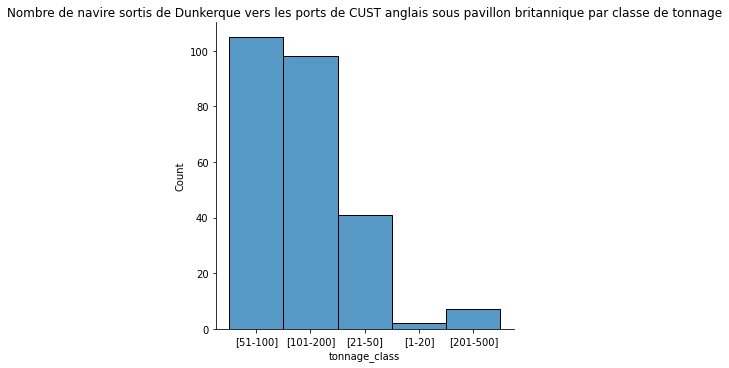

In [204]:

plt.figure(figsize=(7, 5))

ax = sns.displot(pd.DataFrame(data=NAVIGO_GROUPED_MINUS_SMUGGLERS[('british', 'french_flanders')]), x='tonnage_class')

ax.set(title='Nombre de navire sortis de Dunkerque vers les ports de CUST anglais sous pavillon britannique par classe de tonnage')
#ax.set_ylabel('Nombre de sorties', fontsize=8)
#ax.set_xlabel('Classe de tonnage', fontsize=8)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#plt.legend( loc= 'upper right')

#plt.show()
pylab.savefig('distribution_tonnage_surnumeraires_GB_Dunkerque.jpg', bbox_inches='tight', dpi=300)


<Figure size 504x360 with 0 Axes>

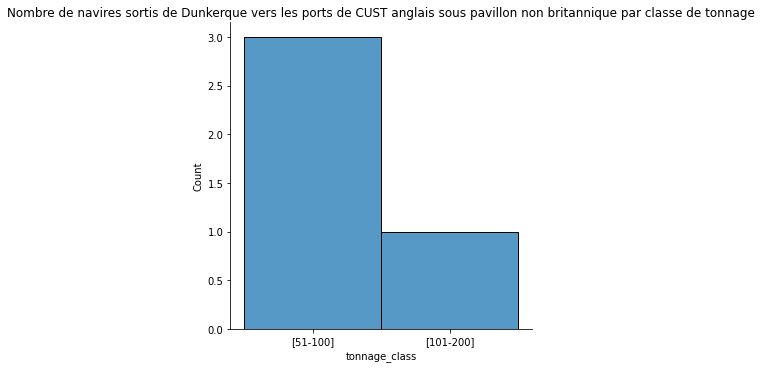

In [205]:
plt.figure(figsize=(7, 5))

ax = sns.displot(pd.DataFrame(data=NAVIGO_GROUPED_MINUS_SMUGGLERS[('foreign', 'french_flanders')]), x='tonnage_class')
ax.set(title='Nombre de navires sortis de Dunkerque vers les ports de CUST anglais sous pavillon non britannique par classe de tonnage')
pylab.savefig('distribution_tonnage_surnumeraires_nonGB_Dunkerque.jpg', bbox_inches='tight', dpi=300)

In [206]:
Counter(row['tonnage'] for row in NAVIGO_GROUPED_MINUS_SMUGGLERS[('british', 'french_flanders')]).most_common(10)

[('100', 28),
 ('110', 24),
 ('60', 18),
 ('80', 18),
 ('70', 14),
 ('180', 9),
 ('150', 9),
 ('130', 8),
 ('125', 8),
 ('32', 7)]

## Que transportent les bateaux de 12 tonneaux?

In [212]:
Counter(row['commodity_purpose'] for row in NAVIGO if row['tonnage'] == '12')

Counter({'genevre': 134,
         'Lège': 150,
         'Cottes de tabac': 1,
         'oziers': 1,
         'Genevre': 430,
         'Etc.': 351,
         'autres marchandises': 24,
         'mousseline': 1,
         'Tabac': 8,
         'Taffetas': 1,
         'tabac': 1,
         'Mousseline': 1,
         'taffia': 4,
         'Taffias': 1,
         'taffias': 1,
         'Eau-de-vie': 4,
         'soieries': 1,
         'Thé': 1})

## Exploration port par port

In [219]:
## Tous navires de navigo 1789 à destination des ports anglais (ceux de CUST)

In [220]:
def navigo_port_group(row):
    return (
        row['destination_uhgs_id'],
        'british' if row['ship_flag_standardized_fr'] == 'britannique' else 'foreign',
        'french_flanders' if row['departure_uhgs_id'] in [DUNKERQUE_UHGS_ID, GRAVELINES_UHGS_ID] else 'french_other'
    )

NAVIGO_GROUPED_PER_PORT = grouped(NAVIGO, key=navigo_port_group)
#NAVIGO_GROUPED_PER_PORT = grouped(NAVIGO_MINUS_12TNX, key=navigo_port_group)

In [221]:
CUST_AGGREGATED_FLOWS_PER_PORT = {}

for row in CUST:
    if row['uhgs_id'] == '#N/A':
        continue
    
    CUST_AGGREGATED_FLOWS_PER_PORT[(row['uhgs_id'], 'british', 'french_flanders')] = int(row['from French Flanders_British vessels_Nb'] or '0')
    CUST_AGGREGATED_FLOWS_PER_PORT[(row['uhgs_id'], 'foreign', 'french_flanders')] = int(row['from French Flanders__foreign_vessels_Nb'] or '0')

In [222]:
for (cust_uhgs_id, cust_flag, cust_from), count in CUST_AGGREGATED_FLOWS_PER_PORT.items():
    if cust_flag != 'british':
        continue
        
    navigo_equivalent = NAVIGO_GROUPED_PER_PORT.get((cust_uhgs_id, cust_flag, cust_from))
    
    if navigo_equivalent is None or not len(navigo_equivalent):
        continue
    
    port_name = UHGS_ID_TO_PORT_NAME[cust_uhgs_id]
    
    #print('For:', port_name, 'CUST:', count, 'NAVIGO:', len(navigo_equivalent), count / len(navigo_equivalent))
    print('|', port_name, '|', count, '|', len(navigo_equivalent), '|', count / len(navigo_equivalent),'|')

| London | 75 | 99 | 0.7575757575757576 |
| Bristol | 0 | 1 | 0.0 |
| Chichester | 0 | 3 | 0.0 |
| Colchester | 0 | 3 | 0.0 |
| Deal | 0 | 1 | 0.0 |
| Dover | 0 | 86 | 0.0 |
| Falmouth | 0 | 1 | 0.0 |
| Faversham | 0 | 1 | 0.0 |
| Harwich | 0 | 31 | 0.0 |
| Hull | 0 | 14 | 0.0 |
| Ipswich | 0 | 2 | 0.0 |
| Lynn Regis | 0 | 11 | 0.0 |
| Malden | 0 | 2 | 0.0 |
| Newcastle | 0 | 19 | 0.0 |
| Newhaven | 0 | 1 | 0.0 |
| Padstow | 0 | 10 | 0.0 |
| Portsmouth | 0 | 1 | 0.0 |
| Rochester | 3 | 3 | 1.0 |
| Sandwich | 0 | 4 | 0.0 |
| Shoreham | 0 | 2 | 0.0 |
| Southampton | 0 | 9 | 0.0 |
| Sunderland | 91 | 77 | 1.1818181818181819 |
| Weymouth | 0 | 3 | 0.0 |
| Whitby | 0 | 1 | 0.0 |
| Whitehaven | 0 | 1 | 0.0 |
| Woodbridge | 0 | 1 | 0.0 |
| Yarmouth | 0 | 19 | 0.0 |


## Comparaison port par port pour les gros navires de navigo à destination des ports anglais (pas les 12 tnx)
On a donc exclu encore une fois les smoggleurs. 


In [216]:
NAVIGO_MINUS_12TNX = [row for row in NAVIGO if row['tonnage']!='12'] 
NAVIGO_GROUPED_PER_PORT = grouped(NAVIGO_MINUS_12TNX, key=navigo_port_group)

for (cust_uhgs_id, cust_flag, cust_from), count in CUST_AGGREGATED_FLOWS_PER_PORT.items():
    if cust_flag != 'british':
        continue
        
    navigo_equivalent = NAVIGO_GROUPED_PER_PORT.get((cust_uhgs_id, cust_flag, cust_from))
    
    if navigo_equivalent is None or not len(navigo_equivalent):
        continue
    
    port_name = UHGS_ID_TO_PORT_NAME[cust_uhgs_id]
    
    print('For:', port_name, 'CUST:', count, 'NAVIGO:', len(navigo_equivalent), count / len(navigo_equivalent))

For: London CUST: 75 NAVIGO: 73 1.0273972602739727
For: Bristol CUST: 0 NAVIGO: 1 0.0
For: Chichester CUST: 0 NAVIGO: 3 0.0
For: Dover CUST: 0 NAVIGO: 2 0.0
For: Falmouth CUST: 0 NAVIGO: 1 0.0
For: Hull CUST: 0 NAVIGO: 14 0.0
For: Ipswich CUST: 0 NAVIGO: 2 0.0
For: Lynn Regis CUST: 0 NAVIGO: 11 0.0
For: Newcastle CUST: 0 NAVIGO: 19 0.0
For: Newhaven CUST: 0 NAVIGO: 1 0.0
For: Padstow CUST: 0 NAVIGO: 10 0.0
For: Portsmouth CUST: 0 NAVIGO: 1 0.0
For: Sandwich CUST: 0 NAVIGO: 4 0.0
For: Southampton CUST: 0 NAVIGO: 9 0.0
For: Sunderland CUST: 91 NAVIGO: 77 1.1818181818181819
For: Weymouth CUST: 0 NAVIGO: 3 0.0
For: Whitby CUST: 0 NAVIGO: 1 0.0
For: Whitehaven CUST: 0 NAVIGO: 1 0.0
For: Woodbridge CUST: 0 NAVIGO: 1 0.0
For: Yarmouth CUST: 0 NAVIGO: 19 0.0
